In [4]:
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
from math import sqrt
from sklearn.svm import SVR, OneClassSVM
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

from scipy.stats import zscore, t

from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import IsolationForest

from sklearn.metrics import mean_squared_error,make_scorer
from sklearn.metrics import r2_score, mean_absolute_error

from sklearn.neighbors import LocalOutlierFactor


from sklearn.feature_selection import RFE,RFECV
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import SelectFromModel


from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,OrdinalEncoder

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import validation_curve
from sklearn.model_selection import learning_curve
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

plt.style.use('ggplot')
import warnings
warnings.filterwarnings('ignore')

In [5]:
def get_soc(kernel,sp,p):
    if kernel=='rbf':
        return sp*(3*p+1)
    if kernel == 'linear':
        return sp*(2*p-1)
    return sp*(2*p+2)

def soc_metric(model,*args,**kwargs):
  X,y=args
  return -get_soc(model.kernel,len(model.support_vectors_),X.shape[1])

In [6]:
uploaded = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'

column_names = ['mpg','cylinders','displacement','horsepower','weight','acceleration','year','origin','name']

df = pd.read_csv(uploaded,delim_whitespace=True,names=column_names)

In [7]:
df=df[df['horsepower']!='?']
df['horsepower']=df['horsepower'].astype('float')
X=df[column_names[1:-1]]
y=df[column_names[0]]
pd.DataFrame(data=[df.skew(),df.kurtosis()],index=['skewness','kurtosis'])

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin
skewness,0.457092,0.508109,0.701669,1.087326,0.519586,0.291587,0.019688,0.915185
kurtosis,-0.515993,-1.398199,-0.778317,0.696947,-0.809259,0.444234,-1.167446,-0.841885


In [8]:
outliers = LocalOutlierFactor(n_neighbors=340).fit_predict(X)
target_out = LocalOutlierFactor(n_neighbors=340).fit_predict(y.values.reshape(-1, 1))
outliers = outliers == 1
target_out = target_out == 1
for i,t in enumerate(target_out):
  outliers[i]=outliers[i] and t

X,y=X[outliers],y[outliers]
X.shape

(391, 7)

In [9]:
X = StandardScaler().fit_transform(X)

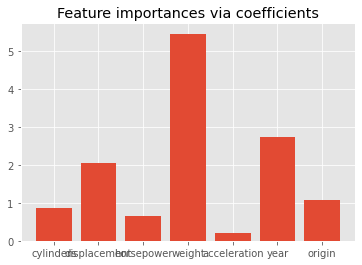

In [10]:
model=LinearRegression()
model.fit(X,y)
feature_importances = np.abs(model.coef_)
feature_names = df.columns.to_numpy()
plt.bar(height=feature_importances, x=feature_names[1:-1])
plt.title("Feature importances via coefficients")
plt.show()

In [11]:
# cv=10
# grid = dict()
# grid['sel__k'] = [i for i in range(1,8)]

# models=[(SVR(kernel='linear'),'SVR'),(LinearRegression(),'LinearRegression')]

# for model,name in models:
#   fs = SelectKBest(score_func=mutual_info_regression)
#   pipeline = Pipeline(steps=[('sel',fs), ('lr', model)])

#   gcv = GridSearchCV(pipeline, grid, scoring='neg_mean_squared_error', n_jobs=-1, cv=cv)

#   results = gcv.fit(X, y)
#   means = results.cv_results_['mean_test_score']
#   params = results.cv_results_['params']
#   params =[d['sel__k'] for d in params]
#   for i in range(len(means)):
#       means[i]=-means[i]
#   plt.plot(params,means,label='MSE vs. k with '+name)
#   plt.legend()
#   plt.xlabel('number of features')
#   plt.ylabel('MSE')
# plt.show()

In [12]:
k=1
X=SelectKBest(score_func=mutual_info_regression,k=k).fit_transform(X,y)

In [15]:
acc_metric = 'neg_mean_squared_error'
cv=10
model_selected=None
minRMSE=np.inf
train_sizes=np.array([0.1,0.2,0.3,0.4,0.5,1.0])

Best Hyperparameters::
{'C': 0.05263157894736842, 'kernel': 'linear'}
Best Hyperparameters::
{'C': 0.2631578947368421, 'kernel': 'linear'}
SOC:  385
MSE:  21.849630821607484 STD:  18.59426287535118


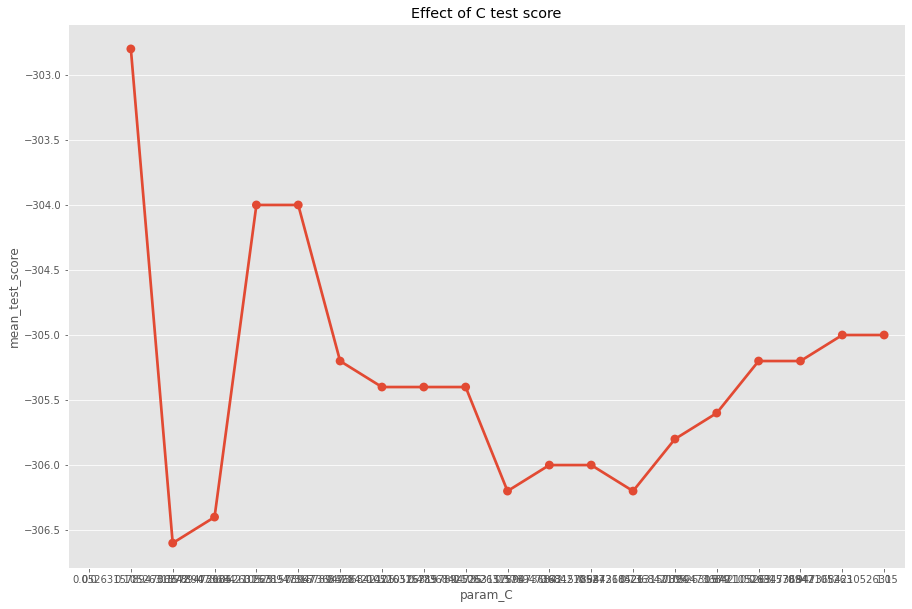

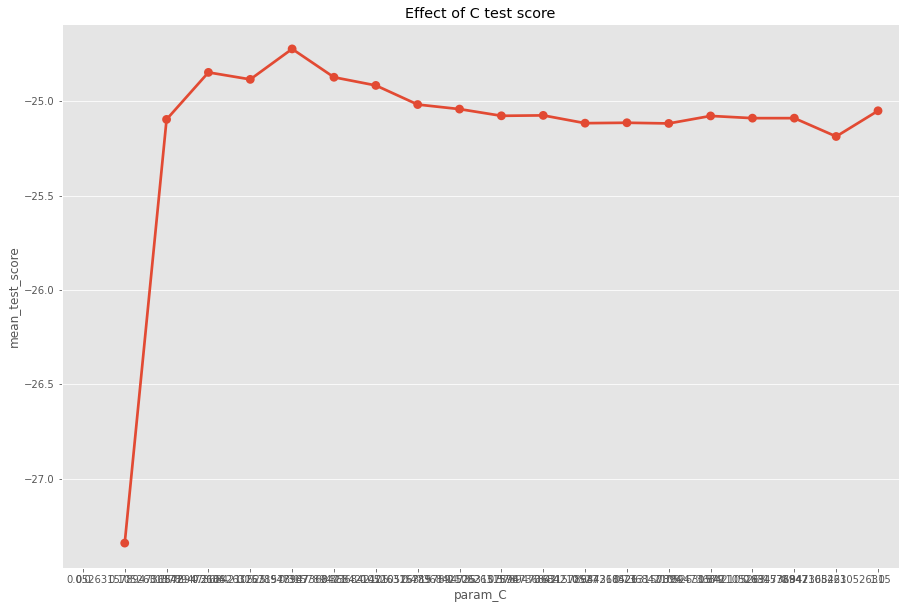

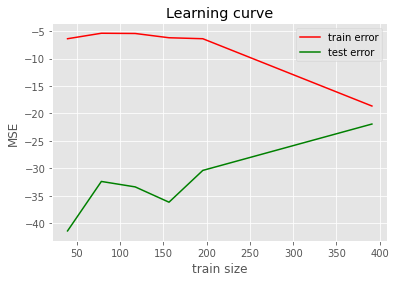

In [16]:
params = {'C':np.linspace(0,1,20),
          'kernel':['linear']}

gcv = GridSearchCV(SVR(),params,cv=5,scoring=soc_metric)
gcv.fit(X,y)
print("Best Hyperparameters::\n{}".format(gcv.best_params_))
results = pd.DataFrame(data=gcv.cv_results_)
fig,ax = plt.subplots(figsize=(15,10))
sns.pointplot(data=results[['mean_test_score',
                           'param_C']],
             y='mean_test_score',x='param_C')
ax.set(title="Effect of C test score")

gcv = GridSearchCV(SVR(),params,cv=5,scoring=acc_metric)
gcv.fit(X,y)
print("Best Hyperparameters::\n{}".format(gcv.best_params_))
results = pd.DataFrame(data=gcv.cv_results_)
fig,ax = plt.subplots(figsize=(15,10))
sns.pointplot(data=results[['mean_test_score',
                           'param_C']],
             y='mean_test_score',x='param_C')
ax.set(title="Effect of C test score")
svr=gcv.best_estimator_
print("SOC: ",len(svr.support_vectors_)*(2*k-1))
_,train_scores,test_scores=learning_curve(svr,X,y,cv=cv,train_sizes=train_sizes,scoring=acc_metric)

mse=cross_val_score(svr,X,y,cv=10,scoring=acc_metric)
std=np.std(mse)
mse=np.abs(np.mean(mse))
print("MSE: ",mse,"STD: ",std)
if mse < minRMSE:
    minRMSE=mse
    model_selected=svr
plt.show()

plt.title("Learning curve")
plt.plot(len(X)*train_sizes,train_scores.mean(axis=1),'r-',label='train error')
plt.plot(len(X)*train_sizes,test_scores.mean(axis=1),'g-',label='test error')
plt.legend()
plt.xlabel('train size')
plt.ylabel('MSE')
plt.show()

Best Hyperparameters::
{'C': 100.0, 'gamma': 1.0, 'kernel': 'rbf'}
Best Hyperparameters::
{'C': 35.938136638046274, 'gamma': 0.046415888336127774, 'kernel': 'rbf'}
# SV 380
SOC:  1520
MSE:  19.22105746045208 STD:  16.003778074770516


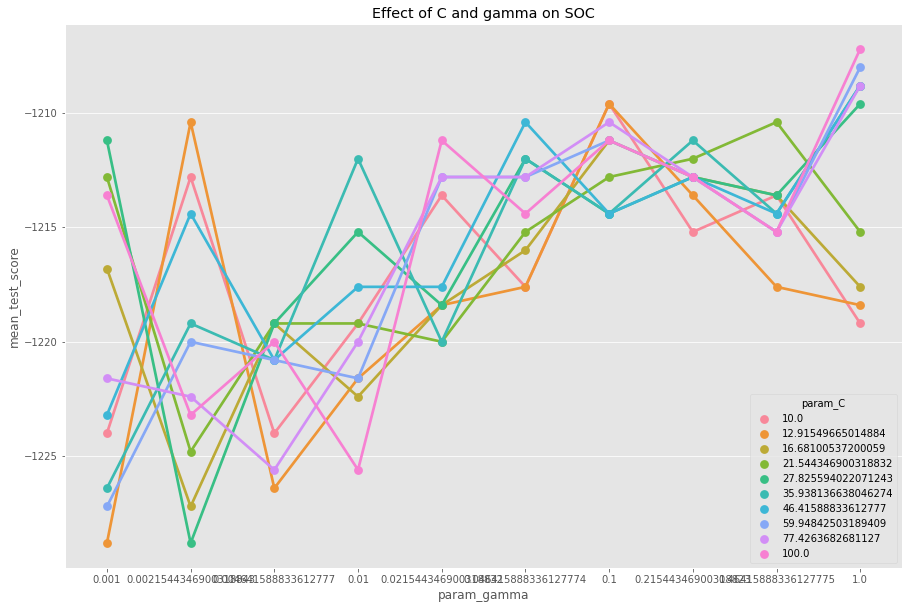

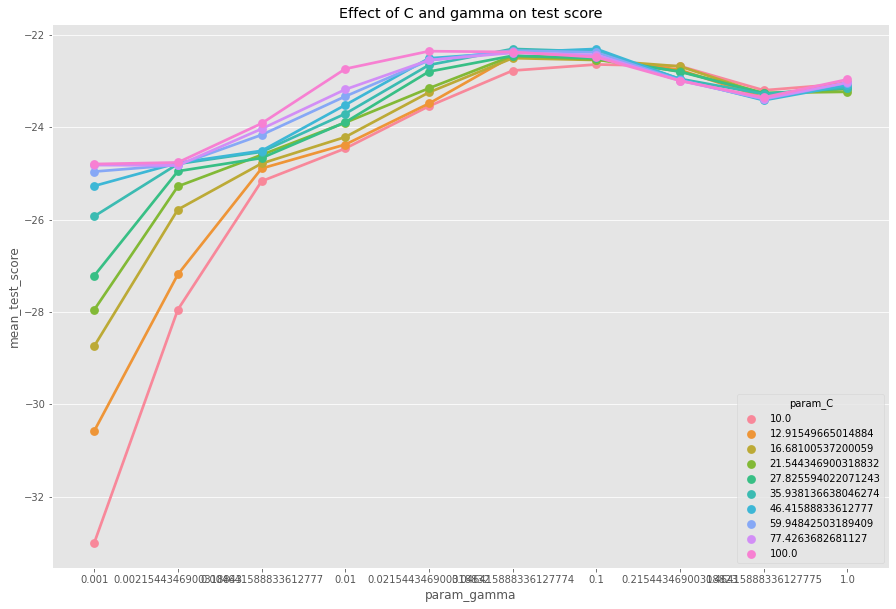

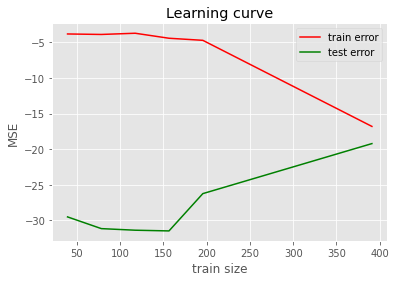

In [21]:
params = {'C':np.logspace(1,2,10),
          'gamma':np.logspace(-3,0,10),
          'kernel':['rbf',]}


gcv = GridSearchCV(SVR(),params,cv=5,scoring=soc_metric)
gcv.fit(X,y)
print("Best Hyperparameters::\n{}".format(gcv.best_params_))
results = pd.DataFrame(data=gcv.cv_results_)
fig,ax = plt.subplots(figsize=(15,10))
sns.pointplot(data=results[['mean_test_score',
                           'param_C',
                           'param_gamma']],
             y='mean_test_score',x='param_gamma',
             hue='param_C',ax=ax)
ax.set(title="Effect of C and gamma on SOC")


gcv = GridSearchCV(SVR(),params,cv=5,scoring=acc_metric)
gcv.fit(X,y)
print("Best Hyperparameters::\n{}".format(gcv.best_params_))
results = pd.DataFrame(data=gcv.cv_results_)
fig,ax = plt.subplots(figsize=(15,10))
sns.pointplot(data=results[['mean_test_score',
                           'param_C',
                           'param_gamma']],
             y='mean_test_score',x='param_gamma',
             hue='param_C',ax=ax)
ax.set(title="Effect of C and gamma on test score")
svr=gcv.best_estimator_
print("# SV",len(svr.support_vectors_))
print("SOC: ",len(svr.support_vectors_)*(3*k+1))
_,train_scores,test_scores=learning_curve(svr,X,y,cv=cv,train_sizes=train_sizes,scoring=acc_metric)

mse=cross_val_score(svr,X,y,cv=10,scoring=acc_metric)
std=np.std(mse)
mse=np.abs(np.mean(mse))
print("MSE: ",mse,"STD: ",std)
if mse < minRMSE:
    minRMSE=mse
    model_selected=svr
plt.show()

plt.title("Learning curve")
plt.plot(len(X)*train_sizes,train_scores.mean(axis=1),'r-',label='train error')
plt.plot(len(X)*train_sizes,test_scores.mean(axis=1),'g-',label='test error')
plt.legend()
plt.xlabel('train size')
plt.ylabel('MSE')
plt.show()

Best Hyperparameters::
{'C': 12.91549665014884, 'gamma': 0.004641588833612777, 'kernel': 'sigmoid'}
Best Hyperparameters::
{'C': 59.94842503189409, 'gamma': 0.004641588833612777, 'kernel': 'sigmoid'}
SOC:  1536
MSE:  21.870502315349643 STD:  18.564263391717635


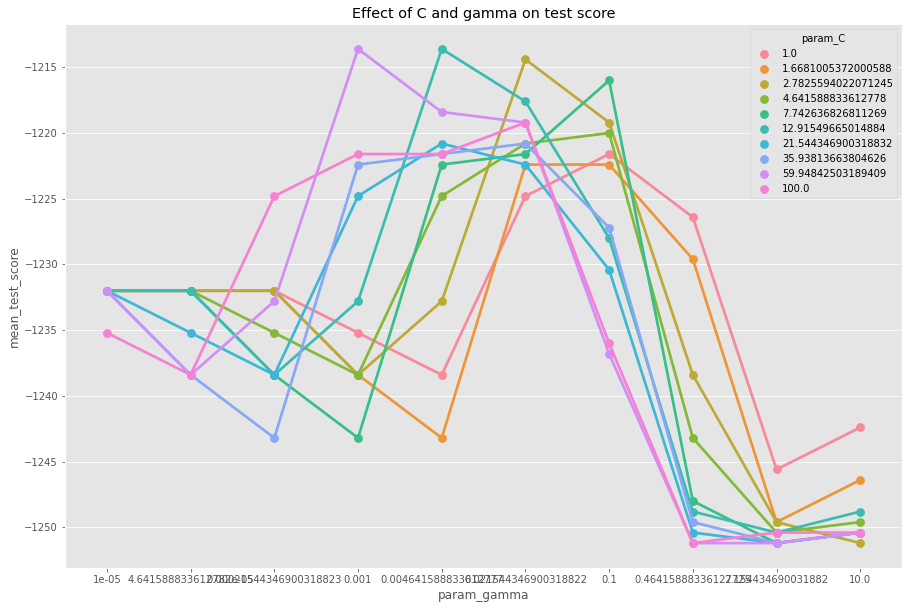

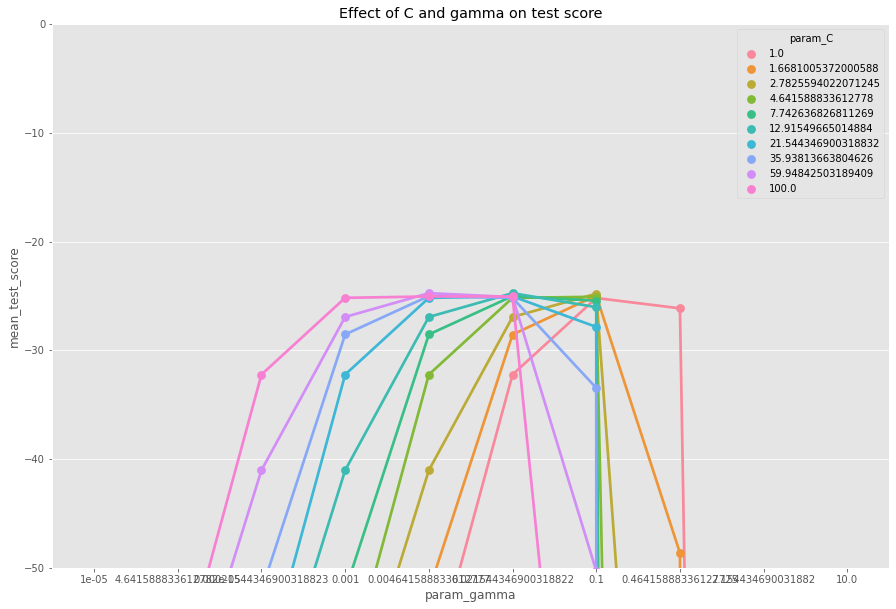

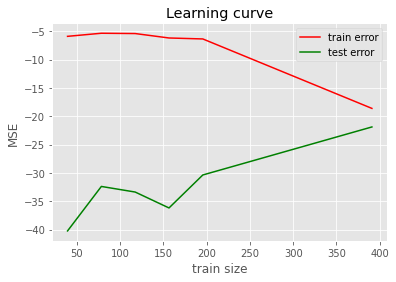

In [20]:
params = {'C':np.logspace(0,2,10),
          'gamma':np.logspace(-5,1,10),
          'kernel':['sigmoid',]}

gcv = GridSearchCV(SVR(),params,cv=5,scoring=soc_metric)
gcv.fit(X,y)
print("Best Hyperparameters::\n{}".format(gcv.best_params_))
results = pd.DataFrame(data=gcv.cv_results_)
fig,ax = plt.subplots(figsize=(15,10))
# ax.set_ylim([-50,0])
sns.pointplot(data=results[['mean_test_score',
                           'param_C',
                           'param_gamma']],
             y='mean_test_score',x='param_gamma',
             hue='param_C',ax=ax)
ax.set(title="Effect of C and gamma on test score")



gcv = GridSearchCV(SVR(),params,cv=5,scoring=acc_metric)
gcv.fit(X,y)
print("Best Hyperparameters::\n{}".format(gcv.best_params_))
results = pd.DataFrame(data=gcv.cv_results_)
fig,ax = plt.subplots(figsize=(15,10))
ax.set_ylim([-50,0])
sns.pointplot(data=results[['mean_test_score',
                           'param_C',
                           'param_gamma']],
             y='mean_test_score',x='param_gamma',
             hue='param_C',ax=ax)
ax.set(title="Effect of C and gamma on test score")
svr=gcv.best_estimator_
print("SOC: ",len(svr.support_vectors_)*(2*k+2))
_,train_scores,test_scores=learning_curve(svr,X,y,cv=cv,train_sizes=train_sizes,scoring=acc_metric)

mse=cross_val_score(svr,X,y,cv=10,scoring=acc_metric)
std=np.std(mse)
mse=np.abs(np.mean(mse))
print("MSE: ",mse,"STD: ",std)
if mse < minRMSE:
    minRMSE=mse
    model_selected=svr
plt.show()

plt.title("Learning curve")
plt.plot(len(X)*train_sizes,train_scores.mean(axis=1),'r-',label='train error')
plt.plot(len(X)*train_sizes,test_scores.mean(axis=1),'g-',label='test error')
plt.legend()
plt.xlabel('train size')
plt.ylabel('MSE')
plt.show()

Best Hyperparameters::
{'C': 0.1, 'degree': 3, 'gamma': 2, 'kernel': 'poly'}
Best Hyperparameters::
{'C': 0.1, 'degree': 3, 'gamma': 0.5, 'kernel': 'poly'}
SOC:  1536
MSE:  40.33995041690778 STD:  28.797527935836534


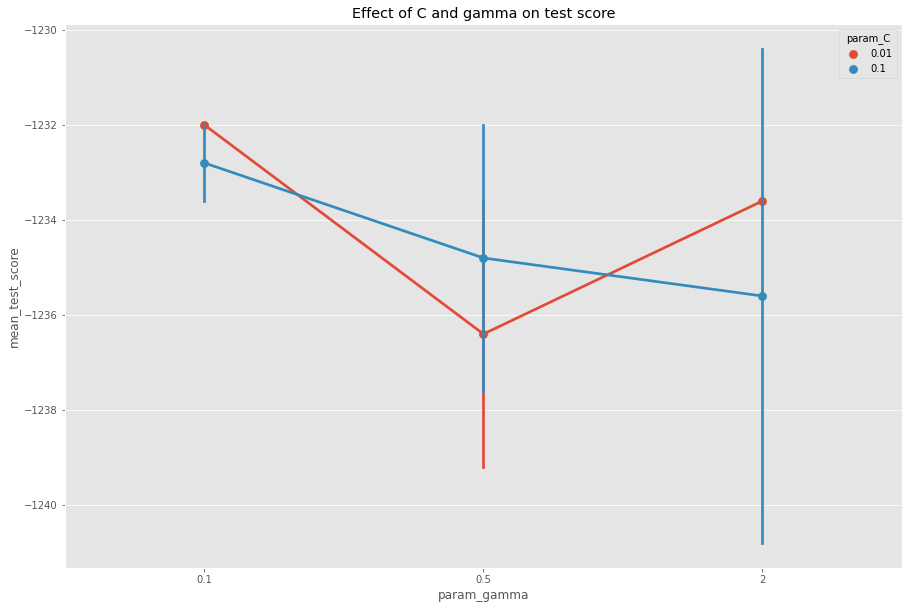

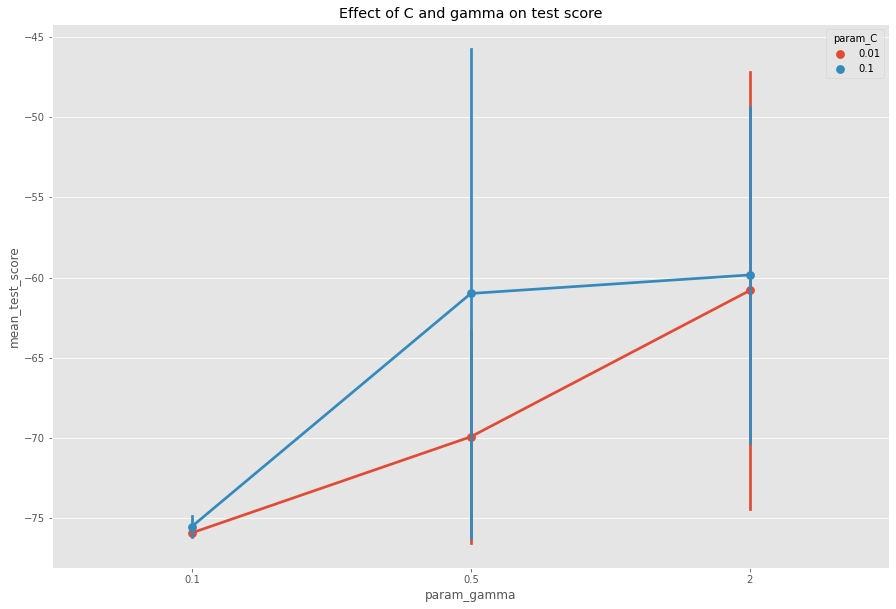

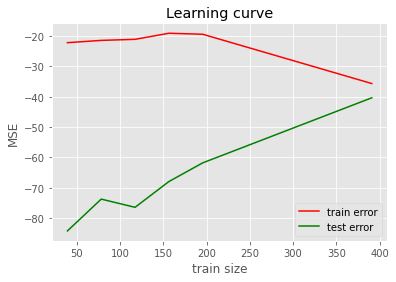

In [19]:
params = {'C':[0.01,0.1],
          'gamma':[0.1,0.5,2],
          'degree':[2,3],
          'kernel':['poly'],
         }

gcv = GridSearchCV(SVR(),params,cv=5,scoring=soc_metric)
gcv.fit(X,y)
print("Best Hyperparameters::\n{}".format(gcv.best_params_))
results = pd.DataFrame(data=gcv.cv_results_)
fig,ax = plt.subplots(figsize=(15,10))
sns.pointplot(data=results[['mean_test_score',
                           'param_C',
                           'param_gamma']],
             y='mean_test_score',x='param_gamma',
             hue='param_C',ax=ax)
ax.set(title="Effect of C and gamma on test score")


gcv = GridSearchCV(SVR(),params,cv=5,scoring=acc_metric)
gcv.fit(X,y)
print("Best Hyperparameters::\n{}".format(gcv.best_params_))
results = pd.DataFrame(data=gcv.cv_results_)
fig,ax = plt.subplots(figsize=(15,10))
sns.pointplot(data=results[['mean_test_score',
                           'param_C',
                           'param_gamma']],
             y='mean_test_score',x='param_gamma',
             hue='param_C',ax=ax)
ax.set(title="Effect of C and gamma on test score")
svr=gcv.best_estimator_
print("SOC: ",len(svr.support_vectors_)*(2*k+2))
__,train_scores,test_scores=learning_curve(svr,X,y,cv=cv,train_sizes=train_sizes,scoring=acc_metric)

mse=cross_val_score(svr,X,y,cv=10,scoring=acc_metric)
std=np.std(mse)
mse=np.abs(np.mean(mse))
print("MSE: ",mse,"STD: ",std)
if mse < minRMSE:
    minRMSE=mse
    model_selected=svr
plt.show()

plt.title("Learning curve")
plt.plot(len(X)*train_sizes,train_scores.mean(axis=1),'r-',label='train error')
plt.plot(len(X)*train_sizes,test_scores.mean(axis=1),'g-',label='test error')
plt.legend()
plt.xlabel('train size')
plt.ylabel('MSE')
plt.show()

In [ ]:
def get_soc(kernel,sp,p):
    if kernel=='rbf':
        return sp*(3*p+1)
    if kernel == 'linear':
        return sp*(2*p-1)
    return sp*(2*p+2)

In [ ]:
soc=get_soc(model_selected.kernel,len(model_selected.support_vectors_),k)
print('Best Model:')
print(model_selected, 'kernel: ',model_selected.kernel)
print('SOC ',soc)
print('MSE ',minRMSE)

Best Model:
SVR(C=35.938136638046274, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
    gamma=0.1, kernel='rbf', max_iter=-1, shrinking=True, tol=0.001,
    verbose=False) kernel:  rbf
SOC  8360
MSE  6.844155446271732


In [ ]:
#SAVE MODEL IN GITHUB
import pickle

!git clone https://github.com/zhumakhan/IML.git
filename='./autompg+svr.model'

with open(filename, 'wb') as file:
    pickle.dump(model_selected,file)

!mv ./autompg+svr.model ./IML/autompg+svr.model
!cd IML && git add . && git commit -m'svr model update' && git push --force
!rm -rf ./IML
# some time later...
# load the model from disk
# loaded_model = pickle.load(open(filename, 'rb'))
# result = loaded_model.score(X_test, Y_test)
# print(result)

Cloning into 'IML'...
remote: Enumerating objects: 51, done.
remote: Counting objects: 100% (51/51), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 51 (delta 29), reused 51 (delta 29), pack-reused 0
Unpacking objects: 100% (51/51), done.

*** Please tell me who you are.

Run

  git config --global user.email "you@example.com"
  git config --global user.name "Your Name"

to set your account's default identity.
Omit --global to set the identity only in this repository.

fatal: unable to auto-detect email address (got 'root@452cf6969059.(none)')
